# Sequential Refinement with GSASII, using pySULI seqRefiner class

The purpose of this notebook is to demonstrate how to do sequential refinement with the pySULI library modules. Sequential refinement is useful for when you have a sequence of related data files; frequently encountered in in-situ experiments.


In [1]:
# We need to import some Python libraries here first.
import os    
import sys
import xarray as xr
import numpy as np
import random
import string
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    %matplotlib widget
except:
    %matplotlib inline

In [2]:
# We need import ipympl packages (if not available pip-install)
try:
    import ipympl
except:
    !! pip install ipympl

Let's check if we are in google colab.

In [3]:
in_colab = True
try:
    from google.colab import drive
except:
    in_colab = False

If in colab, run preperatory methods for using colab. Note that any individual directory strings may be up to change. Otherwise, prepare as we woud on a local machine.

**Crucial note:**
If you are trying to access a directory shared to you, you must create a shortcut to that given directory in your `MyDrive` folder, and then you can access it as we do below (This is how `RTE-24-4876` is accessed below). 

In [4]:
# if running on google colab
if in_colab:
    # setting up a connection to our google drive
    from google.colab import drive
    drive.mount('/content/drive')
    from google.colab import output
    output.enable_custom_widget_manager()

    # setting up the path on the drive to the notebooks, as well as the source code path
    drive_path = '/content/drive/MyDrive/RTE-24-4876/code/pySULI-main/notebooks/'
    os.chdir(drive_path)
    src_path = '/content/drive/MyDrive/RTE-24-4876/code/pySULI-main/src/'
    sys.path += [src_path]

    """
    gsas2_package in here was obtained by the following procedure:
    
    I followed the Linux steps noted here: https://subversion.xray.aps.anl.gov/trac/pyGSAS/wiki/InstallLinux
    - curl https://subversion.xray.aps.anl.gov/admin_pyGSAS/downloads/gsas2full-Latest-Linux-x86_64.sh > /tmp/gsas2full-Latest-Linux-x86_64.sh
    - bash /tmp/gsas2full-Latest-Linux-x86_64.sh -b -p ~/g2full
    
    Instead of ~/g2full I used /content/drive/MyDrive/XRD-on-colab/gsas2_package as install path.
    
    Then I deleted everything except GSASII in /content/drive/MyDrive/XRD-on-colab/gsas2_package folder.
    # There are some redundant stuff (.svn, __pycache__ doc fsource  help PDFfit2 ). I deleted those too.
    """
    
    if not os.path.isdir('gsas2_package'):
    
        print('downlading gsas_package')
        ! gdown 1Mj4zFbWu_qXLTubquLsATeY_bu4qogCO # this is the Google Drive ID for gsas2_package_v5038.zip
        ! unzip gsas2_package_v5038.zip
    
    sys.path += ['gsas2_package/GSASII']
    !pip install pymatgen --use-deprecated=legacy-resolver

if not in_colab:
    sys.path += ['../src']
    # assuming GSAS-II is installed on your machine 
    # as explained here: https://advancedphotonsource.github.io/GSAS-II-tutorials/install.html
    # as a result of "conda create -n GSASII briantoby::gsas2pkg  -c conda-forge", GSAS-II
    # will be installed on a env location. Then we add it to path as below.
    user = "pmeshkov"
    
    match user:
        case "mtopsakal":
            sys.path += ['/home/mt/software/miniforge3/envs/GSASII/GSAS-II/GSASII']
        case "pmeshkov":
            sys.path += ['/opt/anaconda3/envs/GSASII/GSAS-II/GSASII']
        case "kmorell":
            sys.path += ['/Users/kevinmorell/g2full/GSAS-II/GSASII']

In [5]:
import GSASIIscriptable as G2sc
import pybaselines # this comes with gsas2_package
import functions_lib_version as func
import gsas2_functions as rf

from IPython.display import clear_output
#clear_output()

GSAS-II binary directory: /opt/anaconda3/envs/GSASII/GSAS-II/GSASII-bin/mac_64_p3.11_n1.26
7 values read from config file /opt/anaconda3/envs/GSASII/GSAS-II/GSASII/config.py


# Setting up the example data path

In [6]:
example_data_path = 'example_data/seq_xrd_refinement_with_gsas2'
os.chdir(example_data_path)

Setting the specific files to use; note that I am filtering out invalid files by ensuring the start of the file has "20240122" in it.

In [7]:
file_names = [('nc_files/' + file) for file in np.sort(os.listdir('nc_files')) if file[0:8] == "20240122"]
print(file_names)

['nc_files/20240122-124546_count_uid=723d1713__CeO2_T_ramp_to_600C.nc', 'nc_files/20240122-124618_count_uid=fe295dca__CeO2_T_ramp_to_600C.nc', 'nc_files/20240122-124649_count_uid=8dbeea26__CeO2_T_ramp_to_600C.nc', 'nc_files/20240122-124720_count_uid=efbf2cfd__CeO2_T_ramp_to_600C.nc', 'nc_files/20240122-124752_count_uid=76daecd7__CeO2_T_ramp_to_600C.nc']


Creat the sequential refiner object from gsas2_functions.py directory. Note the paths may be different for you; GSASII_path will almost definitely be different, and requires installation on your machine.

In [8]:
myrefiner = rf.seqRefiner(
    nc_paths = file_names,
    phases = [{'cif_abs_path':'_cifs/CeO2.cif','phase_name':'CeO2','scale':1},],
    gsas2_scratch = None,
    q_range = (1,6),
    instrument_parameters_file = 'instprm_and_bkg/gsas.instprm',
    GSASII_path = '/opt/anaconda3/envs/GSASII/GSAS-II/GSASII',
    da_input_bkg = None,
    verbose = False
)

/Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/_cifs/CeO2.cif read by Reader CIF
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/gsas.gpx
/Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/data.xy read by Reader comma/tab/semicolon separated
Instrument parameters read: /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/instprm_and_bkg/gsas.instprm (G2 fmt) bank None
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/gsas.gpx
gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/gsas.gpx
/Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_w

# Start refining with the `Refiner.refine_[var]()` methods

In [9]:
myrefiner.refine_background(20)

gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/gsas.gpx


This method plots the covariance matrix for the refined variables, note that it only plots the variables currently set to refined as true, so for most useful information, call this method after each refinement call individually.

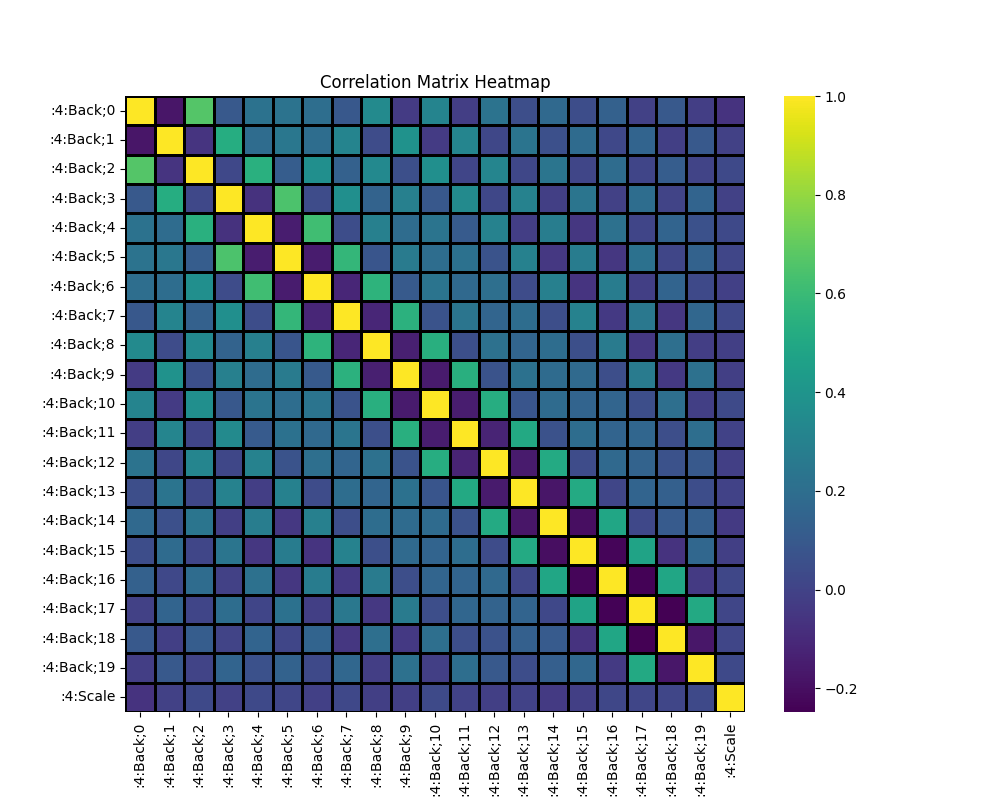

In [10]:
myrefiner.plot_corr_matrix()

gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/gsas.gpx


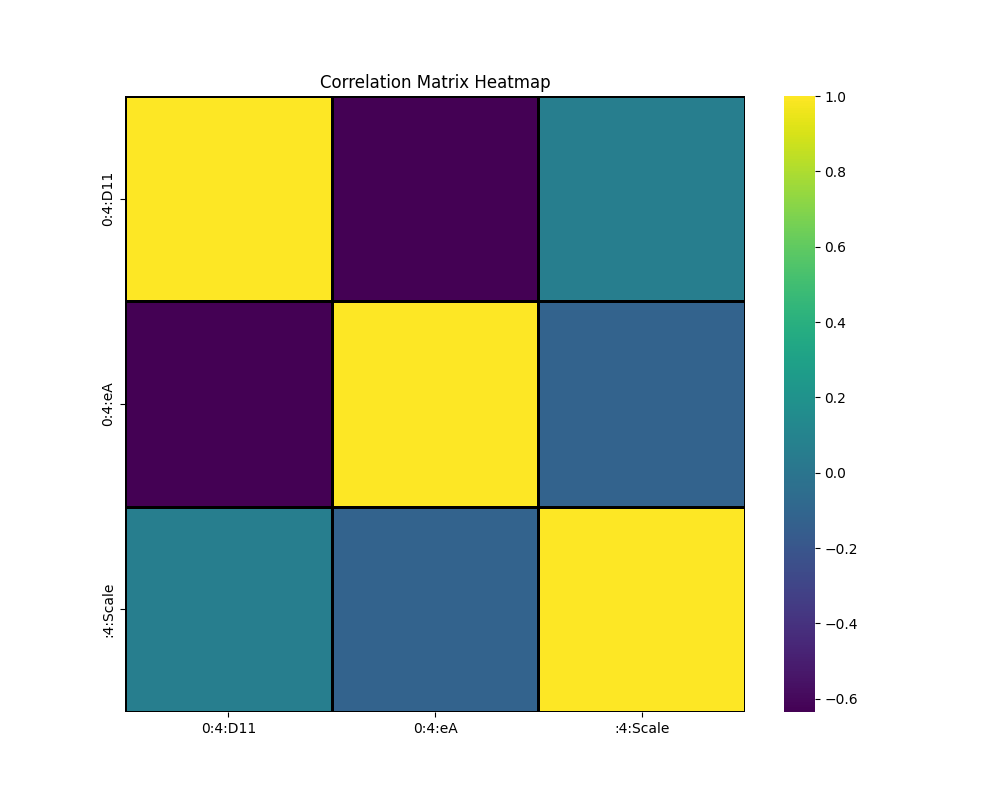

In [11]:
myrefiner.refine_cell_params()
myrefiner.plot_corr_matrix()

gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/gsas.gpx


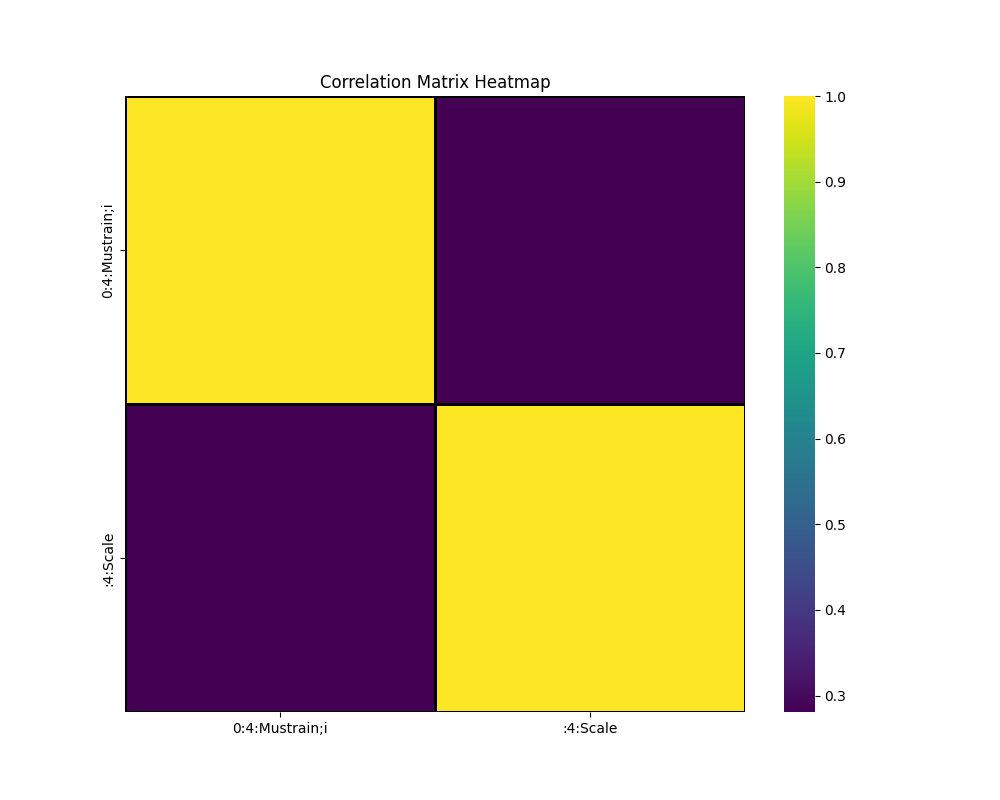

In [12]:
myrefiner.refine_strain_broadening()
myrefiner.plot_corr_matrix()

gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/gsas.gpx


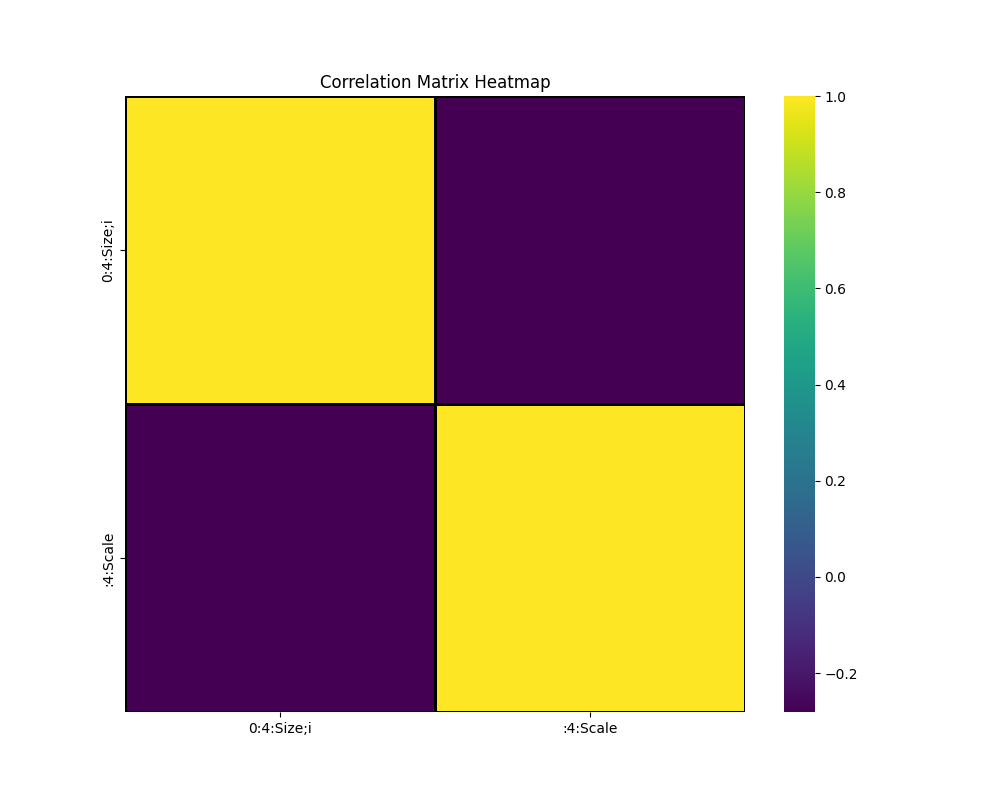

In [13]:
myrefiner.refine_size_broadening()
myrefiner.plot_corr_matrix()

gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/gsas.gpx


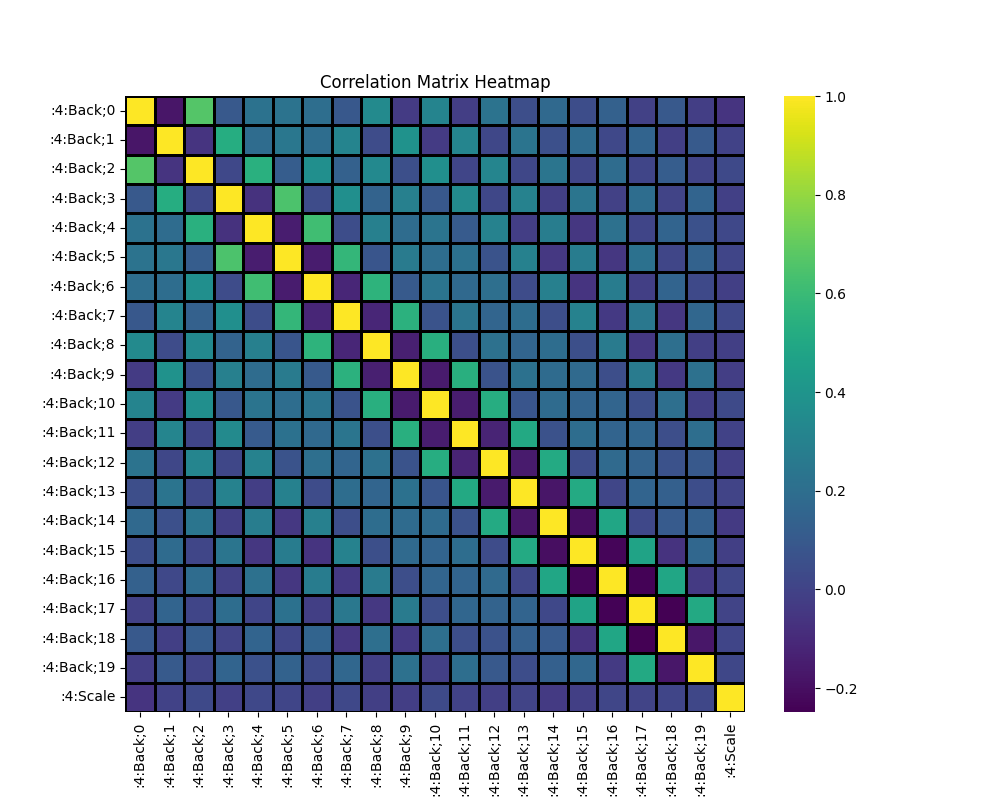

In [14]:
myrefiner.refine_background(20)
myrefiner.plot_corr_matrix()

gpx file saved as /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2/.gsas2_scratch/1722027114.51_88HKUPD.tmp/gsas.gpx


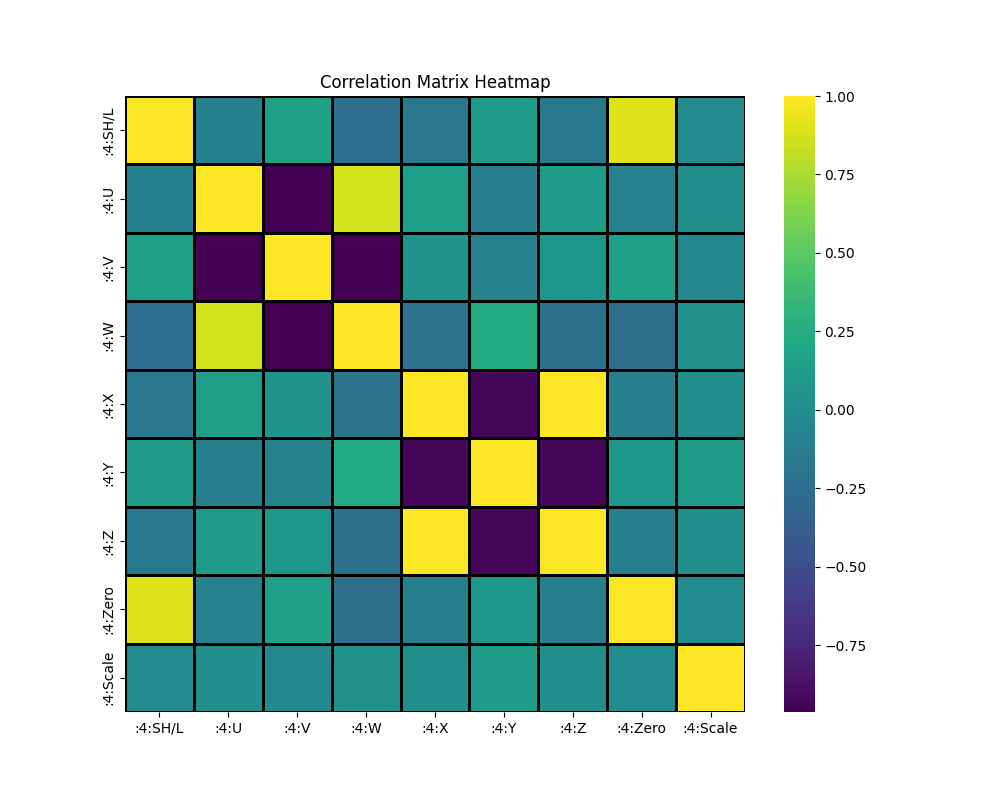

In [15]:
myrefiner.refine_inst_parameters()
myrefiner.plot_corr_matrix()

Save the refinement; this part is mandatory for plotting later, as it saves the results of the refinements in to the ds_dict internal array of data.

In [16]:
gpx, ds_dict = myrefiner.save_refinement()

Create a gif of the refinement results! it will be saves as some file "sequential_ref[random number].gif". For some reason, for now, gif creation does not work in colab. Will figure this out later, but instead for now we just create a plot for each element in the sequential refinement.

6it [00:00,  8.57it/s]                                                          

Gif saved as sequential_ref7966.gif in /Users/petermeshkov/Repos/pySULI/notebooks/example_data/seq_xrd_refinement_with_gsas2


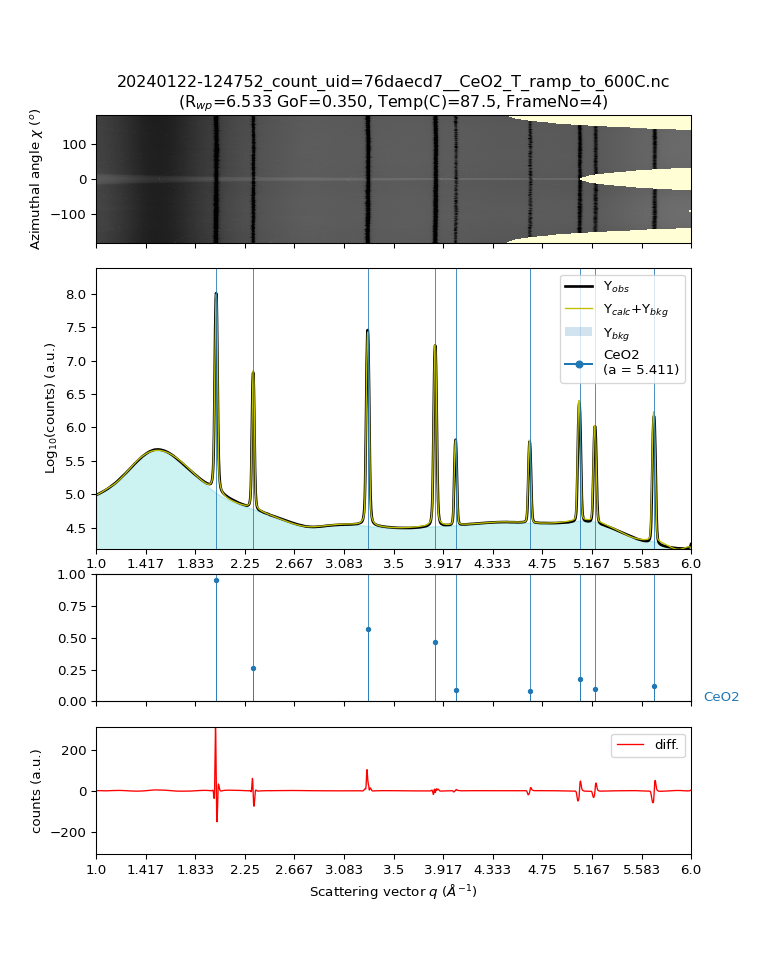

In [18]:
if in_colab:
    for i in range(len(file_names)):
        myrefiner.plot_one(i)
if not in_colab:
    myrefiner.reset_verbose(True)
    myrefiner.plot_all()